# Drill Fixing Assumptions

Judging from the diagnostic plots, your data has a problem with both heteroscedasticity and multivariate non-normality.

In [1]:
#Imports
import math
import warnings

from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

In [20]:
#### Define Functions ######

#Create Normal Test Function
from scipy import stats

def normal_test(data):
    k2, p = stats.normaltest(data)
    alpha = 5e-3
    print("p = {:g}".format(p))

    if p < alpha:  # null hypothesis: x comes from a normal distribution
        print("Probably not a normal distribution")
    else:
        print("Probably a normal distribution")

In [31]:
# Acquire, load, and preview the data.
data = pd.read_csv('https://tf-curricula-prod.s3.amazonaws.com/data-science/Advertising.csv')
display(data.head())

# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = data['Sales'].values.reshape(-1, 1)
X = data[['TV','Radio','Newspaper']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))

,Unnamed: 0,TV,Radio,Newspaper,Sales
0,1,230.100,37.800,69.200,22.100
1,2,44.500,39.300,45.100,10.400
2,3,17.200,45.900,69.300,9.300
3,4,151.500,41.300,58.500,18.500
4,5,180.800,10.800,58.400,12.900



Coefficients: 
 [[ 0.04576465  0.18853002 -0.00103749]]

Intercept: 
 [ 2.93888937]

R-squared:
0.897210638179


## Multivariate Normality

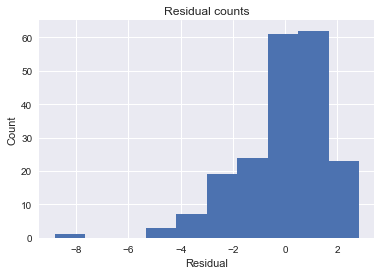

In [4]:
# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = data['Sales']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

In [21]:
print('Residual:')
normal_test(residual.dropna())

Residual:
p = 7.60809e-14
Probably not a normal distribution


Since this skewness can be traced to outliers or skewness, lets look at the underlying data


#### TV

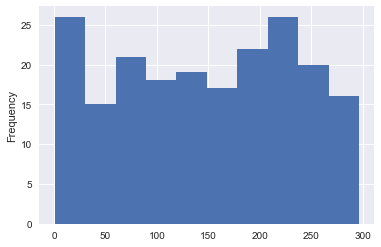

In [6]:
data['TV'].plot(kind='hist')

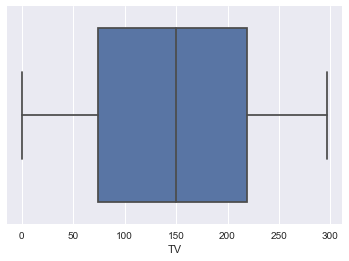

In [7]:
sns.boxplot(data['TV'])

Looks like there are not any outliers, but the data isnt normal. LEts look at ways to get normality

In [29]:
#Normality Test on Raw
print('Raw:')
normal_test(data['TV'].dropna())

#Log
print('Log:')
normal_test(np.log(data['TV'].dropna()))

#Square Root
print('Square Root:')
normal_test(np.sqrt(data['TV'].dropna()))

#Inverse
print('Inverse:')
normal_test(1/data['TV'].dropna())

#Cube root
print('Cube Root:')
normal_test(np.power(data['TV'].dropna(),(1/3)))



Raw:
p = 4.63238e-24
Probably not a normal distribution
Log:
p = 9.13157e-17
Probably not a normal distribution
Square Root:
p = 4.69587e-05
Probably not a normal distribution
Inverse:
p = 1.96783e-91
Probably not a normal distribution
Cube Root:
p = 4.73883e-05
Probably not a normal distribution


Best option would be to do the cube root.

#### Radio

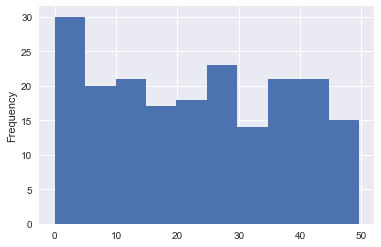

In [16]:
data['Radio'].plot(kind='hist')

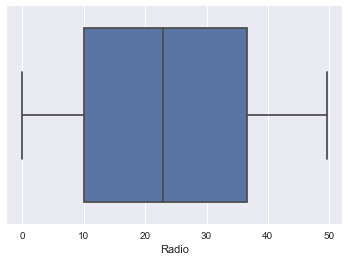

In [17]:
sns.boxplot(data['Radio'])

In [25]:
#Normality Test on Raw
print('Raw:')
normal_test(data['Radio'].dropna())

#Log
print('Log:')
normal_test(np.log(data['Radio'].dropna()))

#Square Root
print('Square Root:')
normal_test(np.sqrt(data['Radio'].dropna()))

#Inverse
print('Inverse:')
normal_test(1/data['Radio'].dropna())

#Cube root
print('Cube Root:')
normal_test(np.power(data['Radio'].dropna(),(1/3)))

Raw:
p = 2.21141e-29
Probably not a normal distribution
Log:
p = nan
Probably a normal distribution
Square Root:
p = 1.05596e-06
Probably not a normal distribution
Inverse:
p = nan
Probably a normal distribution
Cube Root:
p = 0.000279097
Probably not a normal distribution


/Users/brandyn/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/Users/brandyn/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:926: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - np.expand_dims(np.mean(a, axis), axis)


Taking the cube root, will make it better. May improve the skewness since there are no outliers.

#### Newspaper

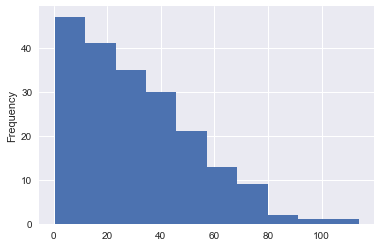

In [26]:
data['Newspaper'].plot(kind='hist')

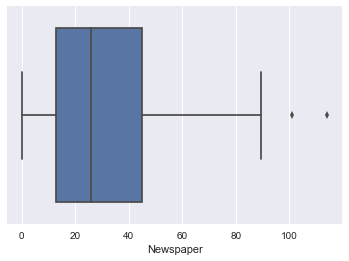

In [27]:
sns.boxplot(data['Newspaper'])

In [28]:
#Normality Test on Raw
print('Raw:')
normal_test(data['Newspaper'].dropna())

#Log
print('Log:')
normal_test(np.log(data['Newspaper'].dropna()))

#Square Root
print('Square Root:')
normal_test(np.sqrt(data['Newspaper'].dropna()))

#Inverse
print('Inverse:')
normal_test(1/data['Newspaper'].dropna())

#Cube root
print('Cube Root:')
normal_test(np.power(data['Newspaper'].dropna(),(1/3)))

Raw:
p = 4.95614e-06
Probably not a normal distribution
Log:
p = 1.94265e-10
Probably not a normal distribution
Square Root:
p = 0.0824897
Probably a normal distribution
Inverse:
p = 1.41517e-80
Probably not a normal distribution
Cube Root:
p = 0.106168
Probably a normal distribution


Making it a cube root, seems to work.

#### Make Transformations

In [32]:
data['Newspaper_Cube'] = np.power(data['Newspaper'].dropna(),(1/3))
data['Radio_Cube'] = np.power(data['Radio'].dropna(),(1/3))
data['TV_Cube'] = np.power(data['TV'].dropna(),(1/3))

In [45]:
#Make new dataframe
updated_data = data[['Newspaper_Cube','Radio_Cube','TV_Cube','Sales']]

#### Rebuild Model

In [46]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = updated_data['Sales'].values.reshape(-1, 1)
X = updated_data[['TV_Cube','Radio_Cube','Newspaper_Cube']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[ 3.02312434  3.50066087  0.14529307]]

Intercept: 
 [-10.75692118]

R-squared:
0.89135645099


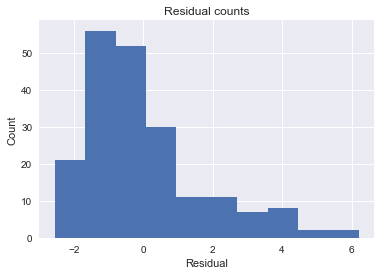

In [47]:
# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = updated_data['Sales']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

In [48]:
print('Residual:')
normal_test(residual.dropna())

Residual:
p = 1.721e-10
Probably not a normal distribution


The normality improved, but still not a normal distribution.

## Homoscedasticity

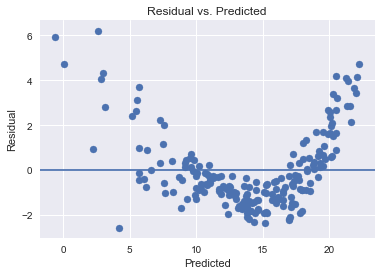

In [49]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()
